In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../gefera')
import gefera as gf

In [2]:
t = np.linspace(67.8, 68.8, 1000)
#t2 = t1 + 365
#t = np.hstack((t1, t2))

ap = 1.0
tp = 0.2
ep = 0.2
pp = 365
wp = 0.1 * np.pi / 180
ip = 90.0 * np.pi / 180

am = 0.007
tm = -1.3
em = 0.1
pm = 3
om = 0.1 * np.pi / 180
wm = 90 * np.pi / 180
im = 88.0 * np.pi / 180
mm = 0.01

u1 = 0.5
u2 = 0.3
rp = 0.2
rm = 0.1

In [11]:
po = gf.PrimaryOrbit(ap, tp, ep, pp, wp, ip)
mo = gf.SatelliteOrbit(am, tm, em, pm, om, wm, im, mm)
sys = gf.HierarchicalSystem(po, mo)
%time lc_ng = sys.lightcurve(t, u1, u2, rp, rm)
%time lc = sys.lightcurve(t, u1, u2, rp, rm, grad=True)[0]
y = lc + np.random.randn(len(lc)) * 0.01

CPU times: user 802 µs, sys: 334 µs, total: 1.14 ms
Wall time: 658 µs
CPU times: user 1.89 ms, sys: 953 µs, total: 2.85 ms
Wall time: 2.32 ms


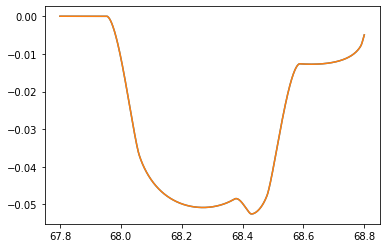

In [12]:
plt.plot(t, lc)
plt.plot(t, lc_ng)

In [ ]:
uniform = lambda x, l, u: 0.0 if ((x > l) & (x < u)) else -np.inf

def log_prior(args):
    
    lsigma, rp, rm, u1, u2, ab, tb, eb, pb, wb, ib, am, tm, em, pm, om, wm, im, mm = args
    
    prior = 0.0 if rm < rp and u1 + u2 < 1 and u1 > 0 and u1 + 2 * u2 > 0 else -np.inf
    
    return (prior 
            + uniform(lsigma, np.log(0.001), np.log(0.1))
            + uniform(rp, 0., 0.5)
            + uniform(rm, 0.0, 0.5)
            + uniform(ab, 0.5, 1.5)
            + uniform(tb, 0.1, 0.3)
            + uniform(eb, 0.0, 1.0)
            + uniform(pb, 300, 400)
            + uniform(wb, -0.0001, 0.5)
            + uniform(ib, 85 * np.pi / 180, 90.1 * np.pi / 180)
            + uniform(am, 0.0, 0.5)
            + uniform(tm, -5.0, 0.0)
            + uniform(em, 0.0, 1.0)
            + uniform(pm, 0.0, 5.0)
            + uniform(om, 0.0, 0.5)
            + uniform(wm, 0.0, np.pi)
            + uniform(im, 0.0, np.pi / 2)
            + uniform(mm, 0.0, 1.0)
    )

def log_like(args, y):
    
    lsigma, rp, rm, u1, u2, ab, tb, eb, pb, wb, ib, am, tm, em, pm, om, wm, im, mm = args
    po = gf.PrimaryOrbit(ab, tb, eb, pb, wb, ib)
    mo = gf.SatelliteOrbit(am, tm, em, pm, om, wm, im, mm)
    sys = gf.HierarchicalSystem(po, mo)
    return sys.loglike(y, t, u1, u2, rp, rm, np.exp(lsigma))

def log_prob(args, y):
    lp = log_prior(args)
    ll = log_like(args, y)
    if np.isfinite(ll):
        return lp + ll
    else:
        return -np.inf

In [ ]:
import emcee

init_params = [np.log(0.01), rp, rm, 0.5, 0.3, ap, tp, ep, pp, wp, ip, am, tm, em, pm, om, wm, im, mm]
pos = init_params + 1e-4 * np.random.randn(50, len(init_params))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(y,)
)
sampler.run_mcmc(pos, 5000, progress=True);

In [ ]:
import corner

flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
fig = corner.corner(
    flat_samples, 
    labels=[
        'sigma', 
        'rp', 
        'rm', 
        'u1', 
        'u2', 
        'ab', 
        'tb', 
        'eb', 
        'pb', 
        'wb', 
        'ib', 
        'am', 
        'tm', 
        'em', 
        'pm', 
        'om', 
        'wm', 
        'im', 
        'mm'
    ]
);

In [ ]:
n = 1000
inds = np.random.randint(len(flat_samples), size=n)
samps = flat_samples[inds]

def getlc(*args):
    _, rp, rm, u1, u2, ab, tb, eb, pb, wb, ib, am, tm, em, pm, om, wm, im, mm = args
    po = gf.PrimaryOrbit(ab, tb, eb, pb, wb, ib)
    mo = gf.SatelliteOrbit(am, tm, em, pm, om, wm, im, mm)
    sys = gf.HierarchicalSystem(po, mo)
    return sys.lightcurve(t, u1, u2, rp, rm)


plt.figure(figsize=(10, 10))
for i in range(n):
    samp = getlc(*samps[i])
    plt.plot(t, samp, color='r', linewidth=2, alpha=0.1)
    
plt.plot(t, y, 'bo', alpha=0.3)
plt.plot(t, lc, 'k-', linewidth=2)

#plt.xlim(67.8, 68.8)
plt.savefig('/Users/tgordon/Desktop/emcee_tmp.pdf')
#plt.xlim(67.8 + 365, 68.8 + 365)
#plt.savefig('/Users/tgordon/Desktop/emcee2.pdf')